In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
from captcha.audio import AudioCaptcha
from captcha.image import ImageCaptcha
import numpy as np
import random
import string
import tensorflow as tf
import tflearn
import pandas as pd

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
from tflearn.data_flow import DataFlow,DataFlowStatus,FeedDictFlow
from tflearn.data_utils import Preloader,ImagePreloader
import scipy
from PIL import Image

In [3]:
GPU_CORE = 0
BATCH_SIZE = 16
dropout = 0.75
rnn_size = 128
bi_layers = 2

In [4]:
width, height, n_len = 130, 70, 6


In [5]:
class CaptchaPreloader(object):
    def __init__(self,width=width,height=height,n_len =4,characters=None):
        if characters == None:
            characters = string.digits + string.ascii_uppercase + string.ascii_lowercase
        self.generator = ImageCaptcha(width=width, height=height)
        self.n_len = n_len
        self.characters = characters
        self.ch2ind = dict(zip(characters,range(len(characters))))
        self.ind2ch = dict(zip(range(len(characters)),characters))

    def __getitem__(self, id):
        retimgs,retstrs = [],[]
        for one in id:
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            img = self.generator.generate_image(random_str)
            retimgs.append(np.asarray(img)),retstrs.append(tflearn.data_utils.to_categorical(
                    [self.ch2ind[i] for i in random_str],nb_classes=len(trainset.characters)))
        return np.asarray(retimgs) / 255 - 0.5,np.asarray(retstrs)

    def __len__(self):
        return 1000000

In [6]:
trainset = CaptchaPreloader()
with tf.device("/gpu:{}".format(GPU_CORE)):
    coord = tf.train.Coordinator()
    trainflow = FeedDictFlow({
            'input_layer':trainset,
        },coord,batch_size=BATCH_SIZE,shuffle=True,continuous=True)
trainflow.start()


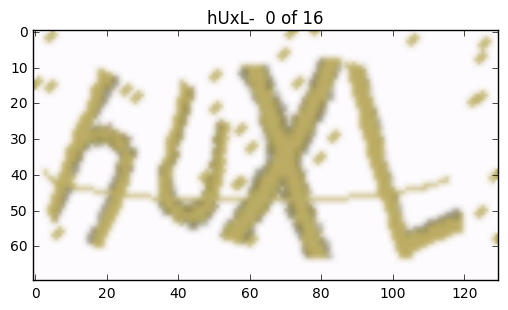

In [7]:
data = trainflow.next()['input_layer']
plt.imshow(np.asarray((data[0][0] + 0.5) * 255,dtype=np.uint8))
actword = ''.join([trainset.ind2ch[i] for i in np.argmax(data[1][0],axis=-1)])
plt.title(actword + "-  0 of {}".format(len(data[0])))

In [8]:
print(data[0].shape,data[1].shape)

(16, 70, 130, 3) (16, 4, 62)


In [9]:
pd.DataFrame(np.argmax(data[1],axis=-1)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,43,48,61,50,47,4,19,15,51,21,32,24,23,58,19,60
1,30,10,34,36,28,21,23,6,57,59,34,33,29,33,43,34
2,59,1,56,12,5,5,28,55,37,57,27,58,38,29,4,48
3,21,33,28,35,3,23,18,22,31,41,53,1,9,16,24,55


# network

In [10]:
TESTIMG_WIDTH = 400

In [21]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
sess = tf.Session(config=config)

with tf.device("/gpu:{}".format(GPU_CORE)):
    inputs = tf.placeholder(tf.float32, [None, width,height,3 ])
    training = tf.placeholder(tf.bool,name='training_mode')
    targets = tf.placeholder(tf.int32,[None,trainset.n_len,len(trainset.characters)])#, shape=np.array([BATCH_SIZE,4], dtype=np.int64))
    learning_rate = tf.placeholder(tf.float32)
    
    #global_step = tf.Variable(0, trainable=False)
    global_step = tf.train.get_or_create_global_step()
    
    net = inputs
    for i in range(4):
        for j in range(2):
            net = tf.layers.conv2d(net, 32*2**i, (3, 3), activation=None, padding='same', name="conv_{}_{}".format(i + 1,j + 1))
            net = tf.layers.batch_normalization(net, training=training, name="bn_conv_{}_{}".format(i + 1,j + 1))
            net = tf.nn.relu(net,name="relu_conv_{}_{}".format(i + 1,j + 1))
        net = tf.layers.max_pooling2d(net, (2, 2), strides=(2, 2), name="pool_{}".format(i + 1))
    
    net = tf.contrib.layers.flatten(net)
    print(net.get_shape())
    net = tf.layers.dropout(net,rate=(1 - dropout))
    
    net_results = [tf.layers.dense(net,len(trainset.characters),activation=None) for i in range(trainset.n_len)]
    net_results = tf.concat([tf.expand_dims(i,axis=1) for i in net_results],axis=1)
    
    with tf.variable_scope("Loss"):
        softmax_loss = tf.losses.softmax_cross_entropy(targets,net_results)
        loss = tf.reduce_mean(softmax_loss)
        tf.summary.scalar("Loss",loss)
    
    with tf.variable_scope("Captcha"):
        tf.summary.image('Captcha',inputs,max_outputs=4)
        
    with tf.variable_scope("LearningRate"):
        tf.summary.scalar("LearningRate",learning_rate)

    
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=MOMENTUM).minimize(cost, global_step=global_step)
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
    #optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss,global_step=global_step)
    
    summary_op = tf.summary.merge_all()
    train_summary_writer = tf.summary.FileWriter("./cnn_train", sess.graph)
    
    
    
    with tf.variable_scope("Accuracy"):
        accuracy = tf.placeholder(tf.float32)
        accuracy_op = tf.summary.scalar("Accuracy",accuracy)
        alphabetaccuracy = tf.placeholder(tf.float32)
        alphabetaccuracy_op = tf.summary.scalar("AlphabetAccuracy",alphabetaccuracy)
        
    with tf.variable_scope("predictions"):
        prediction_result = tf.placeholder(tf.float32, [None, TESTIMG_WIDTH,TESTIMG_WIDTH,3 ])
        prediction_result_op = tf.summary.image("Predictions",prediction_result)

(?, 8192)


In [22]:
sess.run(tf.global_variables_initializer())
tf.train.global_step(sess, global_step)

0

In [23]:
N_BATCH = 5000

In [24]:
from utils import ProgressBar

In [25]:
def accuracy_sent(targ,pred):
    targ_shape = targ.shape
    pred_shape = pred.shape
    predmatrix = np.zeros(targ_shape)
    predmatrix[:,:min(targ_shape[1],pred_shape[1])] = pred[:,:min(targ_shape[1],pred_shape[1])]
    
    alpha_acc = np.average(predmatrix == targ)
    actacc = np.average([all(i == j) for i,j in zip(predmatrix,targ)])
    return alpha_acc,actacc

In [26]:
import io
def gen_plot(batch_x,batch_y,batch_result):
    """Create a pyplot plot and save to buffer."""
    plt.imshow(np.asarray((np.transpose(batch_x[0],[1,0,2]) + 0.5) * 255,dtype=np.uint8))
    actword = ''.join([trainset.ind2ch[i] for i in np.argmax(batch_y[0],axis=-1)])
    predword = ''.join([trainset.ind2ch[i] for i in batch_result[0]])
    plt.title("ori:{}  pred:{}".format(actword,predword))
    #fig.("ori:{}  pred:{}".format(actword,predword))
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.savefig('test.png')
    buf.seek(0)
    return buf


In [27]:
import os
model_name = "conv_model"
if not os.path.exists("models/{}".format(model_name)):
    os.mkdir("models/{}".format(model_name))

In [28]:
net_results.get_shape()

TensorShape([Dimension(None), Dimension(4), Dimension(62)])

In [ ]:
restore = True
N_EPOCH = 50
DECAY_EPOCH = 10

class ExpVal:
    def __init__(self,exp_a=0.97):
        self.val = None
        self.exp_a = exp_a
    def update(self,newval):
        if self.val == None:
            self.val = newval
        else:
            self.val = self.exp_a * self.val + (1 - self.exp_a) * newval
    def getval(self):
        return round(self.val,2)
    
expdis = ExpVal()
expacc = ExpVal()
expabacc = ExpVal()
exploss = ExpVal()


begining_learning_rate = 1e-2

pred_image = None
if restore == False:
    train_epoch = 1
    train_batch = 0
for one_epoch in range(train_epoch,N_EPOCH):
    train_epoch = one_epoch
    pb = ProgressBar(worksum=N_BATCH * BATCH_SIZE,info=" epoch {} batch {}".format(train_epoch,train_batch))
    pb.startjob()
    
    for one_batch in range(N_BATCH):
        if restore == True and one_batch < train_batch:
            pb.auto_display = False
            pb.complete(BATCH_SIZE)
            pb.auto_display = True
            continue
        else:
            restore = False
        train_batch = one_batch
        
        batch_x,batch_y = trainflow.next()['input_layer']
        batch_x = np.transpose(batch_x,[0,2,1,3])

        
        
        # learning rate decay strategy
        batch_lr = begining_learning_rate * 10 ** -(one_epoch // DECAY_EPOCH)
        
        batch_result,_,step_loss,step_summary,step_value = sess.run(
            [net_results,train_op,loss,summary_op,global_step],feed_dict={
                inputs:batch_x,targets:batch_y,learning_rate:batch_lr,training:True
            })
        
        batch_result = np.argmax(batch_result,-1)
        step_abacc,step_acc = accuracy_sent(targ=np.argmax(batch_y,-1),pred=batch_result)
        
        step_acc *= 100
        step_abacc *= 100
        expdis.update(0)
        expacc.update(step_acc)
        exploss.update(step_loss)
        expabacc.update(step_abacc)

        if pred_image is None or one_batch % 100 == 0:
            plot_buf = gen_plot(batch_x,batch_y,batch_result)
            plot_image = Image.open(plot_buf)
            pred_image = np.expand_dims(scipy.misc.imresize(scipy.asarray(plot_image),size=(TESTIMG_WIDTH,TESTIMG_WIDTH)),0)
            pred_image = pred_image[:,:,:,:3]
                      
        ab_ser,ac_ser,pr_ser = sess.run([alphabetaccuracy_op,accuracy_op,prediction_result_op],feed_dict={
                alphabetaccuracy:step_abacc,accuracy:step_acc,prediction_result:pred_image})
        
        pb.info = "EPOCH {} STEP {} LR {} ACC {} ABACC {} LOSS {} DIS {}".format(
            one_epoch,one_batch,batch_lr,expacc.getval(),expabacc.getval(),exploss.getval(),expdis.getval())
        # add trainging statics to tensorboard
        train_summary_writer.add_summary(step_summary, step_value)
        train_summary_writer.add_summary(ab_ser, step_value)
        train_summary_writer.add_summary(ac_ser, step_value)
        train_summary_writer.add_summary(pr_ser, step_value)
        
        pb.complete(BATCH_SIZE)

    print()
    saver = tf.train.Saver()
    saver.save(sess,"models/{}/model".format(model_name))

EPOCH 1 STEP 4999 LR 0.01 ACC 82.49 ABACC 94.98 LOSS 0.17 DIS 0.0 100.00 % [==================================================>] 80000/80000 	 used:420s eta:0 s
EPOCH 2 STEP 4999 LR 0.01 ACC 87.25 ABACC 96.66 LOSS 0.09 DIS 0.0 100.00 % [==================================================>] 80000/80000 	 used:560s eta:0 s
EPOCH 3 STEP 4999 LR 0.01 ACC 91.24 ABACC 97.73 LOSS 0.07 DIS 0.0 100.00 % [==================================================>] 80000/80000 	 used:629s eta:0 s
EPOCH 4 STEP 4999 LR 0.01 ACC 92.09 ABACC 97.88 LOSS 0.07 DIS 0.0 100.00 % [==================================================>] 80000/80000 	 used:699s eta:0 s
EPOCH 5 STEP 4999 LR 0.01 ACC 92.86 ABACC 98.17 LOSS 0.05 DIS 0.0 100.00 % [==================================================>] 80000/80000 	 used:768s eta:0 s
EPOCH 6 STEP 4999 LR 0.01 ACC 93.64 ABACC 98.37 LOSS 0.05 DIS 0.0 100.00 % [==================================================>] 80000/80000 	 used:835s eta:0 s
EPOCH 7 STEP 4999 LR 0.01 ACC 93.3